# CHIKV_Mac HIPPO FFF Prod. 8 (prepare for RRG)

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
import hippo
from pathlib import Path
from mlog import setup_logger
import pandas as pd
import numpy as np
import molparse as mp
logger=setup_logger('notebook')

In [2]:
animal = hippo.HIPPO('CHIKV_prod8b', 'CHIKV_prod8b.sqlite')#, copy_from='CHIKV_prod7.sqlite', overwrite_existing=True)

Creating HIPPO animal
name = CHIKV_prod8b
db_path = CHIKV_prod8b.sqlite
DEBUG: hippo3.Database.__init__()
DEBUG: Database.path = CHIKV_prod8b.sqlite
DEBUG: hippo3.Database.connect()
DEBUG: sqlite3.version='2.6.0'
 SUCCESS  Database connected @ CHIKV_prod8b.sqlite!
 SUCCESS  Initialised animal HIPPO("CHIKV_prod8b")!


## Create the RRG

In [3]:
recipe = hippo.Recipe.from_json(animal.db, 'CHIKV_starting_recipe_yields_fix.json', allow_db_mismatch=True)

 DISK  Reading CHIKV_starting_recipe_yields_fix.json
session = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod8b.sqlite
in file = /opt/xchem-fragalysis-2/maxwin/CHIKV_HIPPO/hippo_prod/CHIKV_prod6.sqlite
 Warning  Database path mismatch
Recipe was generated at: 2024-10-09 09:53:15.372773
reactants = {I x 32}
intermediates = {I x 0}
products = {I x 20}
reactions = {R x 20}


In [4]:
gen = hippo.RandomRecipeGenerator(db=animal.db, start_with=recipe, suppliers=['Stock', 'Enamine'])

DEBUG: RandomRecipeGenerator.__init__()
database = CHIKV_prod8b.sqlite
max_lead_time = None
suppliers = ['Stock', 'Enamine']
 DISK  Writing CHIKV_prod8b_recipes/
DEBUG: Solving route pool...


100%|██████████| 15435/15435 [01:31<00:00, 169.46it/s]


 DISK  Writing CHIKV_prod8b_rgen.json


In [ ]:
gen = hippo.RandomRecipeGenerator.from_json(animal.db, "CHIKV_prod8b_rgen.json")

## Check Quotes / Fingerprints

In [ ]:
animal.db.select_where(table='quote', query='AVG(quote_amount), COUNT(DISTINCT quote_compound)', key='supplier', value='Stock')

In [ ]:
animal.db.select_where(table='interaction', query='COUNT(DISTINCT interaction_pose)', key='interaction_id IS NOT NULL')

In [ ]:
animal.poses

In [ ]:
animal.db.select_where(table='pose', query='COUNT(DISTINCT pose_reference)', key='pose_id IS NOT NULL')

In [ ]:
animal.db.count('route')

In [ ]:
gen.route_pool

## Test generation

In [ ]:
r = gen.generate(shuffle=False, budget=30000, max_products=1200, max_reactions=3000, currency='EUR', debug=False)

In [40]:
r.reactants.df

,compound_id,amount,quote_id,supplier,max_lead_time,quoted_amount
0,85,60.0,10539,Enamine,None,100.0
1,4554,10.0,65,Enamine,None,20.0
2,4466,1.0,36,Enamine,None,20.0
3,4467,1.0,37,Enamine,None,20.0
4,4440,10.0,25,Enamine,None,20.0
...,...,...,...,...,...,...
181,52819,1.0,4096,"[Stock, Enamine]",None,20.0
182,52829,1.0,4098,"[Stock, Enamine]",None,20.0
183,78836,1.0,5033,"[Stock, Enamine]",None,20.0
184,78868,1.0,5040,"[Stock, Enamine]",None,20.0


## Check why impossible routes are in the pool

In [ ]:
sql = """
WITH possible_reactants AS (
			SELECT quote_compound, COUNT(CASE WHEN quote_supplier IN ("Enamine", "Stock") THEN 1 END) AS [count_valid] FROM quote
			GROUP BY quote_compound
		),

		route_reactants AS (
			SELECT route_id, route_product, COUNT(CASE WHEN count_valid = 0 THEN 1 WHEN count_valid IS NULL THEN 1 END) AS [count_unavailable] FROM route
			INNER JOIN component ON component_route = route_id
			LEFT JOIN possible_reactants ON quote_compound = component_ref
			WHERE component_type = 2
			GROUP BY route_id
		)

SELECT COUNT(route_id) FROM route_reactants
WHERE count_unavailable = 0
"""
# AND route_id = 77365

c = animal.db.execute(sql)

results = c.fetchall()
results

In [ ]:
sql = """
WITH possible_reactants AS (
			SELECT quote_compound, COUNT(CASE WHEN quote_supplier IN ("Enamine", "Stock") THEN 1 END) AS [count_valid] FROM quote
			GROUP BY quote_compound
		),

		route_reactants AS (
			SELECT route_id, route_product, count_valid, COUNT(CASE WHEN count_valid = 0 THEN 1 END) AS [count_unavailable] FROM route
			INNER JOIN component ON component_route = route_id
			LEFT JOIN possible_reactants ON quote_compound = component_ref
			WHERE component_type = 2
            GROUP BY route_id
		)

SELECT route_id FROM route_reactants
WHERE count_unavailable = 0
"""

c = animal.db.execute(sql)

results = c.fetchone()
results

In [ ]:
sql = """
WITH possible_reactants AS (
			SELECT quote_compound, COUNT(CASE WHEN quote_supplier IN ("Enamine", "Stock") THEN 1 END) AS [count_valid] FROM quote
			GROUP BY quote_compound
		),

		route_reactants AS (
			SELECT route_id, route_product, component_ref, count_valid, COUNT(CASE WHEN count_valid = 0 THEN 1 WHEN count_valid IS NULL THEN 1 END) AS [count_unavailable] FROM route
			INNER JOIN component ON component_route = route_id
			LEFT JOIN possible_reactants ON quote_compound = component_ref
			WHERE component_type = 2
            AND route_id = 77365
            GROUP BY route_id
		)

SELECT * FROM route_reactants
"""

c = animal.db.execute(sql)

results = c.fetchall()
results

In [ ]:
animal.db.execute("""
SELECT quote_compound, CASE WHEN quote_supplier IN ("Enamine", "Stock") THEN 1 END AS [count_valid] FROM quote
WHERE quote_compound IN (4574,91477)
""").fetchall()

In [ ]:
animal.db.execute("""

""").fetchall()

In [ ]:
route_ids = [r[0] for r in results]
route_products = [r[1] for r in results]
count_unavailable = [r[2] for r in results]
len(route_ids)

In [ ]:
animal.db.get_route(id=1).reactant

In [ ]:
animal.C91478.reactions[0].reactants.ids

In [ ]:
route_id = 77365
route_id in route_ids

In [ ]:
animal.C4574.get_quotes(df=True)

In [ ]:
animal.db.get_route(id=670).reactions.types

## Check missing multi-step chemistry

In [ ]:
inchi = 'YIIMVUSFSKUYCA-UHFFFAOYSA-N'
inchi = 'XXPRWRCNORVHSY-UHFFFAOYSA-N'

In [ ]:
c = animal.compounds[inchi]
c

In [ ]:
recipes = c.get_recipes(quoted_only=False)
len(recipes)

In [ ]:
recipe = recipes[0]

In [ ]:
recipe.sankey()

In [ ]:
recipe.reactions.summary()

In [ ]:
animal.C4449.get_quotes(df=True)

In [ ]:
animal.C4497.get_quotes(df=True)

In [ ]:
animal.C4499.get_quotes(df=True)

In [ ]:
animal.db.select_all_where(table='quote', key='entry', value='EN300-41185')

In [ ]:
animal.C4499.draw()

In [ ]:
animal.C4499.smiles

In [ ]:
animal.compounds(smiles='CNCC(N)=O.HCl')

In [ ]:
c.draw()

In [ ]:
c.poses.interactive()

In [ ]:
animal.P6264.render()

In [ ]:
animal.P6264.draw()

In [ ]:
recipe.reactions

## Check route table

In [6]:
animal.db.execute("SELECT COUNT(DISTINCT route_product) FROM route").fetchone()

(74785,)

In [21]:
sql = """
WITH possible_reactants AS (
			SELECT quote_compound, COUNT(CASE WHEN quote_supplier IN ("Enamine", "Stock") THEN 1 END) AS [count_valid] FROM quote
			GROUP BY quote_compound
		),

		route_reactants AS (
			SELECT route_id, route_product, 
            COUNT(
                CASE 
                    WHEN count_valid = 0 THEN 1 
                    WHEN count_valid IS NULL THEN 1 
                END) 
            AS [count_unavailable] FROM route
			INNER JOIN component ON component_route = route_id
			LEFT JOIN possible_reactants ON quote_compound = component_ref
			WHERE component_type = 2
			GROUP BY route_id
		)

		SELECT route_id, route_product, count_unavailable FROM route_reactants
"""
		# WHERE count_unavailable = 0
ids = animal.db.execute(sql).fetchall()

In [22]:
len(ids)

77475

In [24]:
for id, prod, count in ids[:5]:
    print(id, prod, count)
    

1 91 2
2 91 2
3 92 1
4 93 0
5 95 0


In [25]:
prod_ids = set([b for a,b,c in ids if not c])
len(prod_ids)

15240

In [17]:
elabs = animal.compounds(tag="Syndirella base").elabs
elabs

{C x 76223}

In [18]:
elab_poses = elabs.poses
elab_poses

{P x 111028}

In [19]:
elab_poses.num_inspirations

54

In [20]:
elab_poses.num_inspiration_sets

 19%|█▉        | 2964/15435 [09:04<38:09,  5.45it/s] 


60

In [27]:
pset = animal.compounds[prod_ids].poses
print(pset.num_inspirations)
print(pset.num_inspiration_sets)

33
28


In [29]:
animal.compounds[prod_ids].num_bases_elaborated

27

In [31]:
animal.compounds[prod_ids].bases.elabs

{C x 55350}

In [34]:
for base in animal.compounds[prod_ids].bases:
    reactions = base.reactions
    print(reactions.types)

['Buchwald-Hartwig_amidation_with_amide-like_nucleophile']
['Nucleophilic_substitution_with_amine']
['Buchwald-Hartwig_amination']
['Ester_amidation', 'Ester_amidation']
['Amidation']
['Amidation']
['Sp2-sp2_Suzuki_coupling', 'Sp2-sp2_Suzuki_coupling']
['Amidation']
['Amidation']
['Sp3-sp2_Suzuki_coupling', 'Sp3-sp2_Suzuki_coupling']
['Ester_amidation', 'Ester_amidation', 'Ester_amidation', 'Ester_amidation']
['Amidation']
['Sp3-sp2_Suzuki_coupling', 'Sp3-sp2_Suzuki_coupling']
['Nucleophilic_substitution_with_amine']
['Buchwald-Hartwig_amination']
['Amidation']
['Amidation']
['Amidation']
['Ester_amidation', 'Ester_amidation']
['Buchwald-Hartwig_amination']
['Amidation']
['N-nucleophilic_aromatic_substitution']
['Buchwald-Hartwig_amidation_with_amide-like_nucleophile']
['Buchwald-Hartwig_amination']
['Ester_amidation']
['Buchwald-Hartwig_amination']
['Amidation']


In [42]:
import plotly.express as px
data = [['Buchwald-Hartwig'],
['Nucleophilic_substitution_with_amine'],
['Buchwald'],
['Ester_amidation', 'Ester_amidation'],
['Amidation'],
['Amidation'],
['Sp2-sp2_Suzuki_coupling', 'Sp2-sp2_Suzuki_coupling'],
['Amidation'],
['Amidation'],
['Sp3-sp2_Suzuki_coupling', 'Sp3-sp2_Suzuki_coupling'],
['Ester_amidation', 'Ester_amidation', 'Ester_amidation', 'Ester_amidation'],
['Amidation'],
['Sp3-sp2_Suzuki_coupling', 'Sp3-sp2_Suzuki_coupling'],
['Nucleophilic_substitution_with_amine'],
['Buchwald'],
['Amidation'],
['Amidation'],
['Amidation'],
['Ester_amidation', 'Ester_amidation'],
['Buchwald'],
['Amidation'],
['N-nucleophilic_aromatic_substitution'],
['Buchwald-Hartwig'],
['Buchwald'],
['Ester_amidation'],
['Buchwald'],
['Amidation']]

In [43]:
data = sum(data, [])
data = [dict(type=a) for a in data]

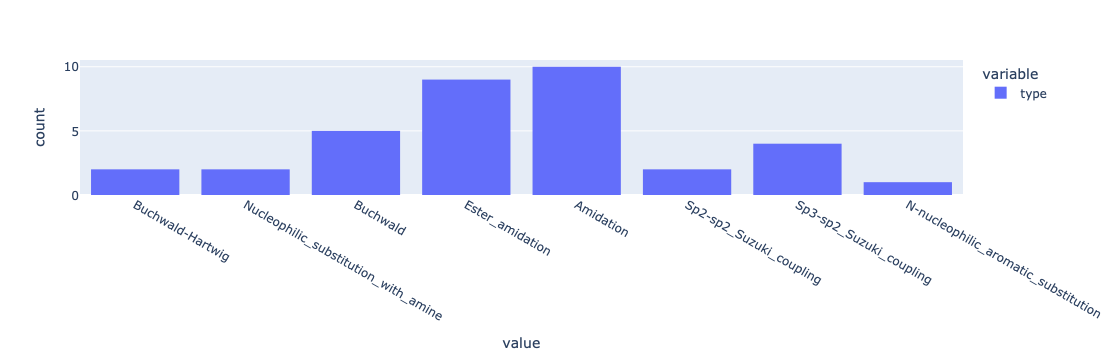

In [44]:
px.histogram(data)